In [1]:
import glob
import pandas as pd
from collections import defaultdict
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore,norm

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [2]:
res = 100000
pvalue_cutoff = 0.05

In [3]:
all_diff_result = glob.glob(f"Call.DiffComp.CellType.Age/*/DifferentialResult/fdr_result/differential.intra_sample_combined.pcQnm.bedGraph")

In [4]:
data_for_df = []
#ct_compart_switch = defaultdict(list)
for path in all_diff_result:
    ct = path.split('/')[1]
    comp =pd.read_csv(path, sep='\t', header=0, index_col=None)
    comp = comp[comp['chr'] != 'chrX']
    #selb = zscore(comp['sample_maha'])>norm.isf(0.025)
    #comp = comp.loc[selb]
    comp.index = comp['chr'] + '_' + (comp['start'] // res).astype(str)
    f_comp = comp[comp['pval'] < pvalue_cutoff]
    f_comp = f_comp.iloc[:,3:6]
    f_comp.columns  = ['8wk','9mo','18mo']
    b_to_a = f_comp[(f_comp["8wk"] < f_comp["18mo"]) & (f_comp["8wk"] <0) & (f_comp["18mo"] > 0) ].shape[0]
    a_to_b = f_comp[(f_comp["8wk"] > f_comp["18mo"]) & (f_comp["8wk"] >0) & (f_comp["18mo"] < 0) ].shape[0]
    weeka_to_stronga = f_comp[(f_comp["8wk"] < f_comp["18mo"]) & (f_comp["8wk"] >0) & (f_comp["18mo"] > 0) ].shape[0]
    stronga_to_weaka = f_comp[(f_comp["8wk"] > f_comp["18mo"]) & (f_comp["8wk"] >0) & (f_comp["18mo"] > 0) ].shape[0]
    weekb_to_strongb = f_comp[(f_comp["8wk"] > f_comp["18mo"]) & (f_comp["8wk"] <0) & (f_comp["18mo"] < 0) ].shape[0]
    strongb_to_weekb = f_comp[(f_comp["8wk"] < f_comp["18mo"]) & (f_comp["8wk"] <0) & (f_comp["18mo"] < 0) ].shape[0]
    
    #ct_compart_switch[ct].append([b_to_a, a_to_b,weeka_to_stronga, stronga_to_weaka, weekb_to_strongb, strongb_to_weekb ])
    data_for_df.append((ct, b_to_a, a_to_b,weeka_to_stronga, stronga_to_weaka, weekb_to_strongb, strongb_to_weekb ) )

In [5]:
df_columns = ['Cell_Type', 'B_to_A', 'A_to_B', 'WeakA_to_StrongA', 'StrongA_to_WeakA', 'WeakB_to_StrongB', 'StrongB_to_WeakB']
comp_switch_df = pd.DataFrame(data_for_df, columns=df_columns).set_index('Cell_Type')
comp_switch_df['more_open'] = comp_switch_df['B_to_A'] + comp_switch_df['WeakA_to_StrongA'] + comp_switch_df['StrongB_to_WeakB']
comp_switch_df['less_open'] = comp_switch_df['A_to_B'] + comp_switch_df['StrongA_to_WeakA'] + comp_switch_df['WeakB_to_StrongB']
comp_switch_df.head()

,B_to_A,A_to_B,WeakA_to_StrongA,StrongA_to_WeakA,WeakB_to_StrongB,StrongB_to_WeakB,more_open,less_open
Cell_Type,,,,,,,,
Vip_Gaba,74,65,110,85,86,65,249,236
MRN-VTN-PPN_Pax5_Cdh23_Gaba,62,45,103,99,63,83,248,207
Astro-NT_NN,63,11,55,23,5,28,146,39
Sst_Gaba,42,28,59,57,39,58,159,124
L23_IT_CTX_Glut,36,54,21,37,35,37,94,126


In [6]:
import joblib
rep_use_cts = joblib.load('rep_use_cts')
comp_switch_df = comp_switch_df.loc[rep_use_cts]

In [7]:
use_cts = comp_switch_df.sum(axis = 1)[comp_switch_df.sum(axis = 1) > 10].index
comp_switch_df = comp_switch_df.loc[use_cts]

In [8]:
# comp_switch_df = comp_switch_df[['more_open','less_open']]
# comp_switch_df = comp_switch_df.div(comp_switch_df.sum(axis=1), axis=0)
# comp_switch_df = comp_switch_df.sort_values('less_open')

In [9]:
comp_switch_df = comp_switch_df[['B_to_A','A_to_B']]
comp_switch_df = comp_switch_df.div(comp_switch_df.sum(axis=1), axis=0)
comp_switch_df = comp_switch_df.sort_values('A_to_B')

In [10]:
ct_order = ['DG_Glut',  'CA1-ProS_Glut','L45_IT_CTX_Glut',  'L6_IT_CTX_Glut', 'MEA-COA_Glut',
       'L6bCT_ENT_Glut', 'L23_IT_PPP_Glut', 'L6_CT_CTX_Glut', 'PAG_Glut','L23_IT_CTX_Glut',
        'Sst_Gaba','STR_D2_Gaba', 'STR-PAL_Chst9_Gaba','Pvalb_Gaba', 
       'CEA-BST_Gaba', 'STR_D1_Gaba',  
       'Astro-NT_NN', 'Microglia_NN','Astro-TE_NN','OPC_NN', 'Oligo_NN', 'VLMC_NN']

In [11]:
comp_switch_df = comp_switch_df.loc[ct_order]

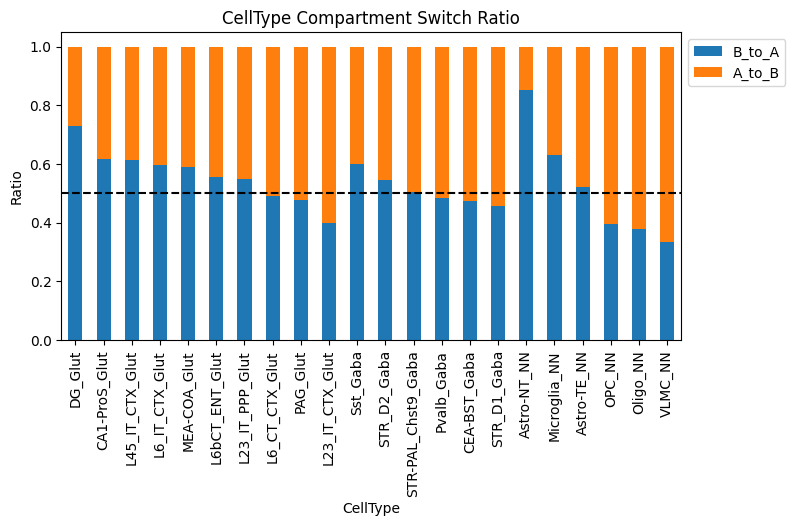

In [12]:
# Create a stacked bar plot
ax = comp_switch_df.plot(kind='bar', stacked=True, figsize = (8,4))

# Set labels and title
plt.xlabel('CellType')
plt.ylabel('Ratio')
plt.title('CellType Compartment Switch Ratio')

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.9))
ax.axhline(y=0.5, c = 'black',linestyle = '--' )
#plt.savefig('figure/diff-comp-ratio.pdf', dpi=300, bbox_inches = 'tight')
# Show the plot
plt.show()


## comp change

In [13]:
data_for_df = []
#ct_compart_switch = defaultdict(list)
for path in all_diff_result:
    ct = path.split('/')[1]
    comp =pd.read_csv(path, sep='\t', header=0, index_col=None)
    #selb = zscore(comp['sample_maha'])>norm.isf(0.025)
    #comp = comp.loc[selb]
    comp.index = comp['chr'] + '_' + (comp['start'] // res).astype(str)
    f_comp = comp[comp['padj'] < pvalue_cutoff]
    f_comp = f_comp.iloc[:,3:6]
    f_comp.columns  = ['8wk','9mo','18mo']
    break
    b_to_a = f_comp[(f_comp["8wk"] < f_comp["18mo"]) & (f_comp["8wk"] <0) & (f_comp["18mo"] > 0) ].shape[0]
    a_to_b = f_comp[(f_comp["8wk"] > f_comp["18mo"]) & (f_comp["8wk"] >0) & (f_comp["18mo"] < 0) ].shape[0]
    weeka_to_stronga = f_comp[(f_comp["8wk"] < f_comp["18mo"]) & (f_comp["8wk"] >0) & (f_comp["18mo"] > 0) ].shape[0]
    stronga_to_weaka = f_comp[(f_comp["8wk"] > f_comp["18mo"]) & (f_comp["8wk"] >0) & (f_comp["18mo"] > 0) ].shape[0]
    weekb_to_strongb = f_comp[(f_comp["8wk"] > f_comp["18mo"]) & (f_comp["8wk"] <0) & (f_comp["18mo"] < 0) ].shape[0]
    strongb_to_weekb = f_comp[(f_comp["8wk"] < f_comp["18mo"]) & (f_comp["8wk"] <0) & (f_comp["18mo"] < 0) ].shape[0]
    
    #ct_compart_switch[ct].append([b_to_a, a_to_b,weeka_to_stronga, stronga_to_weaka, weekb_to_strongb, strongb_to_weekb ])
    data_for_df.append((ct, b_to_a, a_to_b,weeka_to_stronga, stronga_to_weaka, weekb_to_strongb, strongb_to_weekb ) )

In [14]:
f_comp

,8wk,9mo,18mo
chr1_1743,-0.39411,-1.38006,-0.32237
chr10_201,-0.76445,-1.04270,0.25592
chr10_421,0.18343,1.38694,0.49550
chr10_704,2.12087,1.13915,0.85999
chr10_869,0.69684,1.43668,2.06978
chr12_271,1.08616,-0.03619,0.42804
chr12_824,0.69564,1.91991,1.45954
chr12_1167,0.46244,1.57691,1.02258
chr13_90,-0.09388,0.09046,1.15601
chr13_214,-1.40078,-2.08001,-0.80319
